In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
df = pd.read_csv("./Data/cleaned_alzheimer.csv")

selected = {
	"chi2": df[["MMSE", "M/F", "EDUC", "SES"]],
	"f_classif": df[["MMSE", "M/F", "nWBV", "EDUC"]],
	"RandomForestClassifier": df[['MMSE', 'EDUC', 'eTIV', 'nWBV']]
}

X = selected["chi2"]
# X = selected["f_classif"]
# X = selected["RandomForestClassifier"]

# Add Group back
X["Group"] = df["Group"]
X

C:\Users\tshar\AppData\Local\Temp\ipykernel_49912\2750326256.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Group"] = df["Group"]


,MMSE,M/F,EDUC,SES,Group
0,27.0,0,14,2.0,0
1,30.0,0,14,2.0,0
2,28.0,1,18,3.0,0
3,27.0,1,18,3.0,0
4,28.0,0,12,4.0,0
...,...,...,...,...,...
312,28.0,0,16,1.0,1
313,26.0,0,16,1.0,1
314,30.0,1,13,2.0,0
315,30.0,1,13,2.0,0


In [16]:
X.iloc[0].values

array([27.,  0., 14.,  2.,  0.])

In [17]:
class AlhemzheimerDataset(Dataset):
	def __init__(self, df):
		self.data = df

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		row = self.data.iloc[idx].values
		# Last value is target
		return torch.tensor(row[:-1], dtype=torch.float32), torch.tensor(row[-1], dtype=torch.float32)

In [18]:
BATCH_SIZE = 8
NUM_WORKERS = 0

# Data loader
dataset = AlhemzheimerDataset(X)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [19]:
next(iter(train_loader))[0].shape

torch.Size([8, 4])

In [20]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

class AlhemzheimerModel(nn.Module):
	def __init__(self):
		super(AlhemzheimerModel, self).__init__()
		
		self.seq1 = nn.Sequential(
			# Fully Connected layers
			nn.Linear(4, 1),
		)
	
	def forward(self, x):
		x = self.seq1(x)
		return x
	
model = AlhemzheimerModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [21]:
train_losses = []
test_losses = []

In [ ]:
def train(epoch, train_losses):
	running_loss = 0
	model.train()
	loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch}")
	for data, target in loop:
		data, target = data.to(device), target.to(device)
		results = model(data).squeeze(1)  # Forward pass
		optimizer.zero_grad()
		loss = loss_fn(results, target)
		loss.backward()  # Back propogation
		optimizer.step()
		loop.set_postfix(loss=loss.item())
		running_loss += loss.item()
	
	train_losses.append(running_loss / len(train_loader))


def test(test_losses):
	model.eval()
	correct = 0
	test_loss = 0
	with torch.inference_mode():
		for data, target in test_loader:
			data, target = data.to(device), target.to(device)
			results = model(data).squeeze(1)
			test_loss += loss_fn(results, target).item()
			preds = (torch.sigmoid(results) > 0.5).float()  # Binary predictions
			correct += (preds == target).sum().item()

	test_loss /= len(test_loader.dataset)
	accuracy = correct / len(test_loader.dataset)
	test_losses.append(test_loss)
	print(f"Test Loss {test_loss} | Accuracy {accuracy}")

In [23]:
epochs = 10
for epoch in range(1, epochs + 1):
	train(epoch, train_losses)
	test(test_losses)

Test Loss 0.5730231255292892 | Accuracy 0.578125


Test Loss 0.5526227429509163 | Accuracy 0.578125


Test Loss 0.5326894521713257 | Accuracy 0.578125


Test Loss 0.5120349004864693 | Accuracy 0.578125


Test Loss 0.4918803423643112 | Accuracy 0.578125


Test Loss 0.4726071320474148 | Accuracy 0.578125


Test Loss 0.4525343291461468 | Accuracy 0.578125


Test Loss 0.432367074303329 | Accuracy 0.578125


Test Loss 0.4130338039249182 | Accuracy 0.578125


Test Loss 0.39292277209460735 | Accuracy 0.578125


<Axes: >

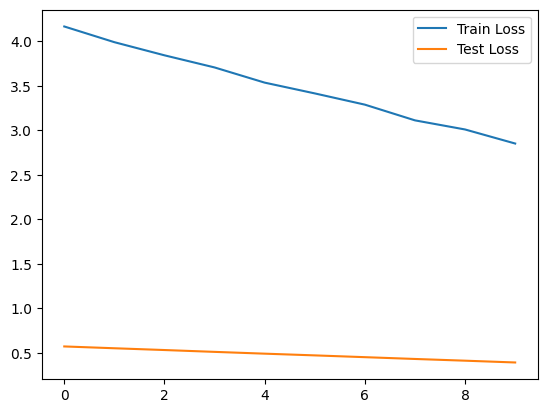

In [26]:
# Plot train loss
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train Loss")
sns.lineplot(x=range(len(test_losses)), y=test_losses, label="Test Loss")